In [51]:
# Import all the required libraries for the project
import tweepy
from twython import Twython
import pandas as pd
import requests
import json
import timeit
from tqdm import tqdm
pd.options.display.max_rows = 1000
import matplotlib.pyplot as plt
import seaborn as sn
import numpy as np
#% matplotlib inline

# Gather data 

## Twitter Archive Data

In [3]:
# read the twitter archive file of weratedogs given by the Udacity
df = pd.read_csv('twitter-archive-enhanced.csv')
df.sample(5)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
1810,676821958043033607,NaN,NaN,2015-12-15 17:51:44 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Finally some constructive political change in ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/676821958...,11,10,None,None,None,None,None
664,790723298204217344,NaN,NaN,2016-10-25 01:14:59 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Happy. He's a bathtub r...,7.899865e+17,4.196984e+09,2016-10-23 00:27:05 +0000,https://twitter.com/dog_rates/status/789986466...,12,10,Happy,None,None,None,None
971,750101899009982464,NaN,NaN,2016-07-04 23:00:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Lilah. She agreed on one quick pic. Now s...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/750101899...,11,10,Lilah,None,None,None,None
655,791784077045166082,NaN,NaN,2016-10-27 23:30:09 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: I'm not sure what this dog is d...,6.820881e+17,4.196984e+09,2015-12-30 06:37:25 +0000,"https://vine.co/v/iqMjlxULzbn,https://vine.co/...",12,10,None,None,None,None,None
121,869596645499047938,NaN,NaN,2017-05-30 16:49:31 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Scout. He just graduated. Officially a...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/869596645...,12,10,Scout,doggo,None,None,None


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

In [5]:
# check for any duplicate rows in the dataset
sum(df.duplicated())

0

In [6]:
# check for null entires in the dataset
df.isna().sum()

tweet_id                         0
in_reply_to_status_id         2278
in_reply_to_user_id           2278
timestamp                        0
source                           0
text                             0
retweeted_status_id           2175
retweeted_status_user_id      2175
retweeted_status_timestamp    2175
expanded_urls                   59
rating_numerator                 0
rating_denominator               0
name                             0
doggo                            0
floofer                          0
pupper                           0
puppo                            0
dtype: int64

## Image Predictions Data

In [7]:
#****************************** ONLY RUN ONCE ******************************
#Use the requests library to download a file and write the contents to a tsv file
r = requests.get('https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv')
file = open("image_predictions.tsv", "w")
file.write(r.text)
file.close()

In [8]:
# Read the image_predictions.tsv file and load the contents to a dataframe
image_predictions = pd.read_csv('image_predictions.tsv', sep = '\t')
image_predictions.sample(5)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
1398,768473857036525572,https://pbs.twimg.com/media/Cqoq5PGWAAA-U8T.jpg,1,Labrador_retriever,0.739170,True,Chesapeake_Bay_retriever,0.246488,True,kelpie,0.006892,True
927,702671118226825216,https://pbs.twimg.com/media/CcBjp2nWoAA8w-2.jpg,1,bloodhound,0.381227,True,Sussex_spaniel,0.212017,True,clumber,0.128622,True
494,675710890956750848,https://pbs.twimg.com/media/CWCbd8ZWoAAtqoH.jpg,2,standard_schnauzer,0.441427,True,miniature_schnauzer,0.248885,True,Sealyham_terrier,0.164967,True
1529,789268448748703744,https://pbs.twimg.com/media/CvQLdotWcAAZn86.jpg,1,malamute,0.812860,True,Siberian_husky,0.120853,True,Eskimo_dog,0.024269,True
1828,835574547218894849,https://pbs.twimg.com/media/C5iOnigWcAAU3Ry.jpg,1,Staffordshire_bullterrier,0.610655,True,muzzle,0.132138,False,American_Staffordshire_terrier,0.109544,True


## Tweet JSON Data

In [9]:
# Set up the Twitter API
consumer_key = 'UrpSBKEnczCU4d4JVTAeghlUs'
consumer_secret = '9utS0oNvO3NYIB0aBu1SAvKSH1EZHXC7xK1SfJz5oaCKG6xd0U'
access_token = '1272812279164276737-yXOvEUHoNgJlFsf4D3KqvMhMnb5PGT'
access_secret = 'B6SfdLIc9hRSYnWZP65xf2ijoez62q5vd55tnFwtX8AkF'

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth, parser=tweepy.parsers.JSONParser(), wait_on_rate_limit=True)

In [10]:
tweet = api.get_status(892420643555336193)
type(api)

tweepy.api.API

In [11]:
tweet_ids = list(df['tweet_id'])

In [12]:
# Use Twitter API to collect status data 
tweet_ids = list(df['tweet_id'])

tweet_data = []
tweet_id_success = []
tweet_id_missing = []
for tweet_id in tqdm(tweet_ids):
    try:
        data = api.get_status(tweet_id, 
                              tweet_mode='extended',
                              wait_on_rate_limit = True,
                              wait_on_rate_limit_notify = True)
        tweet_data.append(data)
        tweet_id_success.append(tweet_id)
    except:
        tweet_id_missing.append(tweet_id)

100%|██████████| 2356/2356 [34:55<00:00,  1.12it/s]    


In [13]:
print("List of success tweets:", len(tweet_id_success))
print("List of missing tweets:", len(tweet_id_missing))

List of success tweets: 2329
List of missing tweets: 27


In [14]:
# Write tweet data to json file
with open('tweet_json.txt', mode = 'w') as file:
    json.dump(tweet_data, file)
    #json.dump(str(tweet_data), file)

In [15]:
# Read the json file to the dataframe
tweet_json = pd.read_json('tweet_json.txt')
tweet_json.sample(5)

,created_at,id,id_str,full_text,truncated,display_text_range,entities,extended_entities,source,in_reply_to_status_id,...,favorited,retweeted,possibly_sensitive,possibly_sensitive_appealable,lang,retweeted_status,quoted_status_id,quoted_status_id_str,quoted_status_permalink,quoted_status
2235,2015-11-20 03:35:20+00:00,667546741521195010,667546741521195008,Here is George. George took a selfie of his ne...,False,"[0, 140]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 667546741093330944, 'id_str'...","<a href=""http://twitter.com"" rel=""nofollow"">Tw...",NaN,...,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN,NaN
1458,2016-01-30 02:41:58+00:00,693262851218264065,693262851218264064,I hope you guys enjoy this beautiful snowy pup...,False,"[0, 97]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 693262842930159616, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN,NaN
2013,2015-12-01 04:22:29+00:00,671544874165002241,671544874165002240,Interesting dog here. Very large. Purple. Mani...,False,"[0, 140]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 671544869609857024, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN,NaN
1005,2016-06-22 01:50:58+00:00,745433870967832576,745433870967832576,This is Lenox. She's in a wheelbarrow. Silly d...,False,"[0, 99]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 745433859332898817, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN,NaN
1994,2015-12-02 15:57:30+00:00,672082170312290304,672082170312290304,This is Patch. He wants to be a Christmas tree...,False,"[0, 77]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 672082162695471104, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN,NaN


In [16]:
# Consider only the required columns
tweet_json_new = tweet_json[['id','retweet_count','favorite_count']]
tweet_json_new.sample(5)

,id,retweet_count,favorite_count
104,871515927908634625,3179,18924
976,747933425676525569,2509,6553
2069,670755717859713024,101,421
591,797545162159308800,4932,14728
1062,738156290900254721,628,2472


In [17]:
tweet_json_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2329 entries, 0 to 2328
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   id              2329 non-null   int64
 1   retweet_count   2329 non-null   int64
 2   favorite_count  2329 non-null   int64
dtypes: int64(3)
memory usage: 54.7 KB


In [18]:
# check for any duplicate rows in the dataset
sum(tweet_json_new.duplicated())

0

In [19]:
# check for null entires in the dataset
tweet_json_new.isna().sum()

id                0
retweet_count     0
favorite_count    0
dtype: int64

# Access data

In [73]:
### let us make a copy the original dataframe
df_clean = df.copy()
image_predictions_clean = image_predictions.copy()
tweet_json_new_clean = tweet_json_new.copy()

In [21]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

In [22]:
# Check for the numerator ratings that are incorrect
df_clean['rating_numerator'].value_counts()

12      558
11      464
10      461
13      351
9       158
8       102
7        55
14       54
5        37
6        32
3        19
4        17
1         9
2         9
420       2
0         2
15        2
75        2
80        1
20        1
24        1
26        1
44        1
50        1
60        1
165       1
84        1
88        1
144       1
182       1
143       1
666       1
960       1
1776      1
17        1
27        1
45        1
99        1
121       1
204       1
Name: rating_numerator, dtype: int64

There are some extreme values like 1776, 204, 960, etc. that could be errors

In [23]:
df_clean['rating_denominator'].value_counts()

10     2333
11        3
50        3
80        2
20        2
2         1
16        1
40        1
70        1
15        1
90        1
110       1
120       1
130       1
150       1
170       1
7         1
0         1
Name: rating_denominator, dtype: int64

There are denominator which is greater than 10 which is incorrect

In [24]:
# Denominator ratings not equal to 10
df_clean.query('rating_denominator != 10').count()[0]

23

In [25]:
df_clean['name'].value_counts()

None              745
a                  55
Charlie            12
Lucy               11
Oliver             11
Cooper             11
Lola               10
Tucker             10
Penny              10
Winston             9
Bo                  9
the                 8
Sadie               8
an                  7
Daisy               7
Toby                7
Bailey              7
Buddy               7
Stanley             6
Koda                6
Dave                6
Scout               6
Rusty               6
Jax                 6
Oscar               6
Leo                 6
Bella               6
Milo                6
Jack                6
Louis               5
Chester             5
Gus                 5
Oakley              5
Finn                5
Sunny               5
George              5
Sammy               5
Alfie               5
very                5
Phil                5
Bentley             5
Larry               5
Bruce               4
Riley               4
Jerry               4
Bear      

There are some names which are incorrectly spelt and also there are some single letter names which should be corrected.

In [26]:
image_predictions_clean.sample(5)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
710,685307451701334016,https://pbs.twimg.com/media/CYKzfTTWMAEeTN7.jpg,1,Pomeranian,0.963176,True,Shetland_sheepdog,0.019468,True,keeshond,0.008605,True
752,688116655151435777,https://pbs.twimg.com/media/CYyucekVAAESj8K.jpg,1,pug,0.973819,True,Chihuahua,0.010891,True,Staffordshire_bullterrier,0.006864,True
190,669393256313184256,https://pbs.twimg.com/media/CUopnHPVEAAcL2o.jpg,1,cocker_spaniel,0.359843,True,Blenheim_spaniel,0.139519,True,toy_poodle,0.132746,True
373,672988786805112832,https://pbs.twimg.com/media/CVbvjKqW4AA_CuD.jpg,1,Lakeland_terrier,0.836632,True,West_Highland_white_terrier,0.073900,True,wire-haired_fox_terrier,0.038160,True
191,669564461267722241,https://pbs.twimg.com/media/CUrFUvDVAAA9H-F.jpg,1,toy_poodle,0.623685,True,miniature_poodle,0.259920,True,standard_poodle,0.082530,True


In [27]:
image_predictions_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [28]:
image_predictions_clean.describe()

,tweet_id,img_num,p1_conf,p2_conf,p3_conf
count,2.075000e+03,2075.000000,2075.000000,2.075000e+03,2.075000e+03
mean,7.384514e+17,1.203855,0.594548,1.345886e-01,6.032417e-02
std,6.785203e+16,0.561875,0.271174,1.006657e-01,5.090593e-02
min,6.660209e+17,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,6.764835e+17,1.000000,0.364412,5.388625e-02,1.622240e-02
50%,7.119988e+17,1.000000,0.588230,1.181810e-01,4.944380e-02
75%,7.932034e+17,1.000000,0.843855,1.955655e-01,9.180755e-02
max,8.924206e+17,4.000000,1.000000,4.880140e-01,2.734190e-01


In [29]:
# Check for tweet duplicates in image_predictions
image_predictions_clean[image_predictions_clean['tweet_id'].duplicated()]

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog


In [30]:
# check for null entires in the dataset
image_predictions_clean.isna().sum()

tweet_id    0
jpg_url     0
img_num     0
p1          0
p1_conf     0
p1_dog      0
p2          0
p2_conf     0
p2_dog      0
p3          0
p3_conf     0
p3_dog      0
dtype: int64

In [31]:
# check for any duplicate entries
image_predictions_clean.nunique()

tweet_id    2075
jpg_url     2009
img_num        4
p1           378
p1_conf     2006
p1_dog         2
p2           405
p2_conf     2004
p2_dog         2
p3           408
p3_conf     2006
p3_dog         2
dtype: int64

We see that there are duplicated values the jpg_url column which should be resolved

In [32]:
sum(image_predictions_clean['jpg_url'].duplicated())

66

We see that the column 'jpg_url' has 66 duplicate url's

In [33]:
# Check for 1st predictions that actually predict as dogs
image_predictions_clean.query('p1_dog == True').count()[0]

1532

In [34]:
# Check for 2nd predictions that actually predict as dogs
image_predictions_clean.query('p2_dog == True').count()[0]

1553

In [35]:
# Check for 3rd predictions that actually predict as dogs
image_predictions_clean.query('p3_dog == True').count()[0]

1499

In [36]:
# Total number of predictions that didnt predict as dogs
image_predictions_clean[(image_predictions_clean['p1_dog']==False) & \
                        (image_predictions_clean['p2_dog']==False) & \
                        (image_predictions_clean['p3_dog']==False)].count()[0]

324

In [37]:
tweet_json_new_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2329 entries, 0 to 2328
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   id              2329 non-null   int64
 1   retweet_count   2329 non-null   int64
 2   favorite_count  2329 non-null   int64
dtypes: int64(3)
memory usage: 54.7 KB


In [38]:
sum(tweet_json_new_clean.duplicated())

0

In [39]:
# check for duplicate tweet ids
sum(tweet_json_new_clean['id'].duplicated())

0

## Clean the Data

## Tidiness Issues

1. Merge the three dataframes with respect to the tweet_id.
2. The different dog types column in the twitter archive data can be put into a single column

## Quality Issues

Twitter Archive data
1. Remove the retweets as we are interested only in original tweets.
2. Drop the unnecessary columns (in_reply_to_status_id, in_reply_to_user_id, retweeted_status_id, retweeted_status_user_id, retweeted_status_timestamp)
3. Change the datatype of timestamp, rating_numerator, rating_denominator columns.
4. The name column in the table has incorrect dog names.
5. The rating_denominator column has incorrect ratings (ratings greater than 10)

Image Predictions Data

1. The column 'jpg_url' has duplicate entries. Those should be dropped.
2. The columns p1, p2, p3 has inconsistent names. Change it to Title case.
3. The column names p1_dog, p2_dog, p3_dog can be renamed to meaningful names.

Tweet Json Data

1. The id column name should be changed to 'tweet_id' for consistency.

### Remove the retweets as we are interested in only original tweets and also remove unnecesaary columns from the Twitter Archive Data

In [74]:
df_clean[df_clean['retweeted_status_id'].notnull()].index

Int64Index([  19,   32,   36,   68,   73,   74,   78,   91,   95,   97,
            ...
             926,  937,  943,  949, 1012, 1023, 1043, 1242, 2259, 2260],
           dtype='int64', length=181)

In [75]:
df_clean.drop(df_clean[df_clean['retweeted_status_id'].notnull()].index, inplace = True)

### Test

In [76]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2175 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2175 non-null   object 
 4   source                      2175 non-null   object 
 5   text                        2175 non-null   object 
 6   retweeted_status_id         0 non-null      float64
 7   retweeted_status_user_id    0 non-null      float64
 8   retweeted_status_timestamp  0 non-null      object 
 9   expanded_urls               2117 non-null   object 
 10  rating_numerator            2175 non-null   int64  
 11  rating_denominator          2175 non-null   int64  
 12  name                        2175 non-null   object 
 13  doggo                       2175 

In [77]:
# Remove the Unnecessary columns
df_clean.drop(['in_reply_to_status_id', 'in_reply_to_user_id', 
               'retweeted_status_id', 'retweeted_status_user_id', 'retweeted_status_timestamp', 'expanded_urls'], axis=1, inplace=True)

In [78]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet_id            2175 non-null   int64 
 1   timestamp           2175 non-null   object
 2   source              2175 non-null   object
 3   text                2175 non-null   object
 4   rating_numerator    2175 non-null   int64 
 5   rating_denominator  2175 non-null   int64 
 6   name                2175 non-null   object
 7   doggo               2175 non-null   object
 8   floofer             2175 non-null   object
 9   pupper              2175 non-null   object
 10  puppo               2175 non-null   object
dtypes: int64(3), object(8)
memory usage: 203.9+ KB


### The datatypes of the timestamp, rating_numerator, rating_denominator needs to be changed

In [79]:
# change the timestamp datatype to datetime type
df_clean['timestamp'] = pd.to_datetime(df_clean['timestamp'])

In [80]:
# change the int datatype to float type
df_clean[['rating_numerator', 'rating_denominator']] = df_clean[['rating_numerator', 'rating_denominator']].astype(float)

### Test

In [81]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   tweet_id            2175 non-null   int64              
 1   timestamp           2175 non-null   datetime64[ns, UTC]
 2   source              2175 non-null   object             
 3   text                2175 non-null   object             
 4   rating_numerator    2175 non-null   float64            
 5   rating_denominator  2175 non-null   float64            
 6   name                2175 non-null   object             
 7   doggo               2175 non-null   object             
 8   floofer             2175 non-null   object             
 9   pupper              2175 non-null   object             
 10  puppo               2175 non-null   object             
dtypes: datetime64[ns, UTC](1), float64(2), int64(1), object(7)
memory usage: 203.9+ KB


### The different dog types columns in the twitter archive data can be put into a single column

In [82]:
df_clean.head(3)

,tweet_id,timestamp,source,text,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,2017-08-01 16:23:56+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,13.0,10.0,Phineas,,,,
1,892177421306343426,2017-08-01 00:17:27+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,13.0,10.0,Tilly,,,,
2,891815181378084864,2017-07-31 00:18:03+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,12.0,10.0,Archie,,,,


In [83]:
df_clean.groupby(["doggo", "floofer", "pupper", "puppo"]).size().reset_index().rename(columns={0: "count"})

,doggo,floofer,pupper,puppo,count
0,,,,,1831
1,,,,puppo,24
2,,,pupper,,224
3,,floofer,,,9
4,doggo,,,,75
5,doggo,,,puppo,1
6,doggo,,pupper,,10
7,doggo,floofer,,,1


In [84]:
df_clean.doggo.replace('None', '', inplace=True)
df_clean.doggo.replace(np.NaN, '', inplace=True)
df_clean.pupper.replace('None', '', inplace=True)
df_clean.pupper.replace(np.NaN, '', inplace=True)
df_clean.puppo.replace('None', '', inplace=True)
df_clean.puppo.replace(np.NaN, '', inplace=True)
df_clean.floofer.replace('None', '', inplace=True)
df_clean.floofer.replace(np.NaN, '', inplace=True)

In [85]:
df_clean['dog_stage'] = df_clean.doggo + df_clean.floofer + df_clean.pupper + df_clean.puppo
df_clean.loc[df_clean.dog_stage == 'doggopupper', 'dog_stage'] = 'doggo, pupper'
df_clean.loc[df_clean.dog_stage == 'doggopuppo', 'dog_stage'] = 'doggo, puppo'
df_clean.loc[df_clean.dog_stage == 'doggofloofer', 'dog_stage'] = 'doggo, floofer'

### Test

In [86]:
df_clean.dog_stage.value_counts()

                  1831
pupper             224
doggo               75
puppo               24
doggo, pupper       10
floofer              9
doggo, puppo         1
doggo, floofer       1
Name: dog_stage, dtype: int64

In [88]:
# drop the other dog stage columns
df_clean.drop(["doggo", "floofer", "pupper", "puppo"], inplace = True, axis = 1)

In [93]:
df_clean.head(20)

,tweet_id,timestamp,source,text,rating_numerator,rating_denominator,name,dog_stage
0,892420643555336193,2017-08-01 16:23:56+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,13.0,10.0,Phineas,
1,892177421306343426,2017-08-01 00:17:27+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,13.0,10.0,Tilly,
2,891815181378084864,2017-07-31 00:18:03+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,12.0,10.0,Archie,
3,891689557279858688,2017-07-30 15:58:51+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,13.0,10.0,Darla,
4,891327558926688256,2017-07-29 16:00:24+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,12.0,10.0,Franklin,
5,891087950875897856,2017-07-29 00:08:17+00:00,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a majestic great white breaching ...,13.0,10.0,None,
6,890971913173991426,2017-07-28 16:27:12+00:00,"<a href=""http://twitter.com/download/iphone"" r...",Meet Jax. He enjoys ice cream so much he gets ...,13.0,10.0,Jax,
7,890729181411237888,2017-07-28 00:22:40+00:00,"<a href=""http://twitter.com/download/iphone"" r...",When you watch your owner call another dog a g...,13.0,10.0,None,
8,890609185150312448,2017-07-27 16:25:51+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Zoey. She doesn't want to be one of th...,13.0,10.0,Zoey,
9,890240255349198849,2017-07-26 15:59:51+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Cassie. She is a college pup. Studying...,14.0,10.0,Cassie,doggo


In [94]:
# Sort by dogs_stage then drop duplicated based on tweet_id except the last occurrence
df_clean = df_clean.sort_values('dog_stage').drop_duplicates(subset='tweet_id', keep='last')

### Test

In [95]:
df_clean['dog_stage'].value_counts()

                  1831
pupper             224
doggo               75
puppo               24
doggo, pupper       10
floofer              9
doggo, puppo         1
doggo, floofer       1
Name: dog_stage, dtype: int64

In [96]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 168
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   tweet_id            2175 non-null   int64              
 1   timestamp           2175 non-null   datetime64[ns, UTC]
 2   source              2175 non-null   object             
 3   text                2175 non-null   object             
 4   rating_numerator    2175 non-null   float64            
 5   rating_denominator  2175 non-null   float64            
 6   name                2175 non-null   object             
 7   dog_stage           2175 non-null   object             
dtypes: datetime64[ns, UTC](1), float64(2), int64(1), object(4)
memory usage: 152.9+ KB


### The rating_numerator, rating_denominator column has incorrect ratings, so manually change these ratings with respect to the text

In [97]:
df_clean['rating_numerator'].value_counts()

12.0      500
10.0      442
11.0      426
13.0      307
9.0       156
8.0        98
7.0        54
14.0       43
5.0        36
6.0        32
3.0        19
4.0        17
2.0         9
1.0         8
0.0         2
420.0       2
17.0        1
99.0        1
165.0       1
1776.0      1
204.0       1
45.0        1
666.0       1
75.0        1
121.0       1
27.0        1
960.0       1
15.0        1
144.0       1
20.0        1
26.0        1
50.0        1
80.0        1
44.0        1
182.0       1
60.0        1
88.0        1
24.0        1
84.0        1
143.0       1
Name: rating_numerator, dtype: int64

In [98]:
# check for the texts that have decimals and replace the rating_numerator and rating_denominator to the values in the text
with pd.option_context('max_colwidth', 200):
    display(df_clean[df_clean['text'].str.contains(r"(\d+\.\d*\/\d+)")]
            [['tweet_id', 'text', 'rating_numerator', 'rating_denominator']])

C:\Users\Bindushree\anaconda3\envs\test_env\lib\site-packages\pandas\core\strings.py:1954: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


,tweet_id,text,rating_numerator,rating_denominator
1689,681340665377193984,I've been told there's a slight possibility he's checking his mirror. We'll bump to 9.5/10. Still a menace,5.0,10.0
1712,680494726643068929,Here we have uncovered an entire battalion of holiday puppers. Average of 11.26/10 https://t.co/eNm2S6p9BD,26.0,10.0
695,786709082849828864,"This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wuqaPS",75.0,10.0
45,883482846933004288,"This is Bella. She hopes her smile made you smile. If not, she is also offering you her favorite monkey. 13.5/10 https://t.co/qjrljjt948",5.0,10.0
763,778027034220126208,This is Sophie. She's a Jubilant Bush Pupper. Super h*ckin rare. Appears at random just to smile at the locals. 11.27/10 would smile back https://t.co/QFaUiIHxHq,27.0,10.0


In [99]:
# manually change the values for the respective tweet ids
df_clean.loc[(df_clean.tweet_id == 786709082849828864), 'rating_numerator'] = 9.5
df_clean.loc[(df_clean.tweet_id == 680494726643068929), 'rating_numerator'] = 11.26
df_clean.loc[(df_clean.tweet_id == 681340665377193984), 'rating_numerator'] = 9.5
df_clean.loc[(df_clean.tweet_id == 883482846933004288), 'rating_numerator'] = 13.5
df_clean.loc[(df_clean.tweet_id == 778027034220126208), 'rating_numerator'] = 11.27

### Test

In [100]:
with pd.option_context('max_colwidth', 200):
    display(df_clean[df_clean['text'].str.contains(r"(\d+\.\d*\/\d+)")]
            [['tweet_id', 'text', 'rating_numerator', 'rating_denominator']])

C:\Users\Bindushree\anaconda3\envs\test_env\lib\site-packages\pandas\core\strings.py:1954: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


,tweet_id,text,rating_numerator,rating_denominator
1689,681340665377193984,I've been told there's a slight possibility he's checking his mirror. We'll bump to 9.5/10. Still a menace,9.50,10.0
1712,680494726643068929,Here we have uncovered an entire battalion of holiday puppers. Average of 11.26/10 https://t.co/eNm2S6p9BD,11.26,10.0
695,786709082849828864,"This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wuqaPS",9.50,10.0
45,883482846933004288,"This is Bella. She hopes her smile made you smile. If not, she is also offering you her favorite monkey. 13.5/10 https://t.co/qjrljjt948",13.50,10.0
763,778027034220126208,This is Sophie. She's a Jubilant Bush Pupper. Super h*ckin rare. Appears at random just to smile at the locals. 11.27/10 would smile back https://t.co/QFaUiIHxHq,11.27,10.0


In [101]:
df_clean['rating_denominator'].value_counts()

10.0     2153
50.0        3
20.0        2
11.0        2
80.0        2
70.0        1
120.0       1
16.0        1
40.0        1
150.0       1
7.0         1
15.0        1
0.0         1
130.0       1
110.0       1
170.0       1
90.0        1
2.0         1
Name: rating_denominator, dtype: int64

We have ratings above 10 that is incorrect, lets try to resolve this

In [103]:
pd.set_option('display.max_colwidth', -1)
df_clean.loc[df_clean.rating_denominator!=10,['tweet_id','text','rating_numerator','rating_denominator']]

C:\Users\Bindushree\anaconda3\envs\test_env\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  """Entry point for launching an IPython kernel.


,tweet_id,text,rating_numerator,rating_denominator
1598,686035780142297088,"Yes I do realize a rating of 4/20 would've been fitting. However, it would be unjust to give these cooperative pups that low of a rating",4.0,20.0
1635,684222868335505415,Someone help the girl is being mugged. Several are distracting her while two steal her shoes. Clever puppers 121/110 https://t.co/1zfnTJLt55,121.0,110.0
1634,684225744407494656,"Two sneaky puppers were not initially seen, moving the rating to 143/130. Please forgive us. Thank you https://t.co/kRK51Y5ac3",143.0,130.0
1779,677716515794329600,IT'S PUPPERGEDDON. Total of 144/120 ...I think https://t.co/ZanVtAtvIq,144.0,120.0
1663,682808988178739200,"I'm aware that I could've said 20/16, but here at WeRateDogs we are very professional. An inconsistent rating scale is simply irresponsible",20.0,16.0
1662,682962037429899265,This is Darrel. He just robbed a 7/11 and is in a high speed police chase. Was just spotted by the helicopter 10/10 https://t.co/7EsP8LmSp5,7.0,11.0
1274,709198395643068416,"From left to right:\nCletus, Jerome, Alejandro, Burp, &amp; Titson\nNone know where camera is. 45/50 would hug all at once https://t.co/sedre1ivTK",45.0,50.0
1202,716439118184652801,This is Bluebert. He just saw that both #FinalFur match ups are split 50/50. Amazed af. 11/10 https://t.co/Kky1DPG4iq,50.0,50.0
1254,710658690886586372,Here's a brigade of puppers. All look very prepared for whatever happens next. 80/80 https://t.co/0eb7R1Om12,80.0,80.0
1228,713900603437621249,Happy Saturday here's 9 puppers on a bench. 99/90 good work everybody https://t.co/mpvaVxKmc1,99.0,90.0


### Code

In [104]:
# check for the denominator ratings which are != 10 and manually change the values
pd.set_option('display.max_colwidth', -1)
df_clean.loc[df_clean.rating_denominator!=10,['tweet_id','text','rating_numerator','rating_denominator']]

C:\Users\Bindushree\anaconda3\envs\test_env\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  


,tweet_id,text,rating_numerator,rating_denominator
1598,686035780142297088,"Yes I do realize a rating of 4/20 would've been fitting. However, it would be unjust to give these cooperative pups that low of a rating",4.0,20.0
1635,684222868335505415,Someone help the girl is being mugged. Several are distracting her while two steal her shoes. Clever puppers 121/110 https://t.co/1zfnTJLt55,121.0,110.0
1634,684225744407494656,"Two sneaky puppers were not initially seen, moving the rating to 143/130. Please forgive us. Thank you https://t.co/kRK51Y5ac3",143.0,130.0
1779,677716515794329600,IT'S PUPPERGEDDON. Total of 144/120 ...I think https://t.co/ZanVtAtvIq,144.0,120.0
1663,682808988178739200,"I'm aware that I could've said 20/16, but here at WeRateDogs we are very professional. An inconsistent rating scale is simply irresponsible",20.0,16.0
1662,682962037429899265,This is Darrel. He just robbed a 7/11 and is in a high speed police chase. Was just spotted by the helicopter 10/10 https://t.co/7EsP8LmSp5,7.0,11.0
1274,709198395643068416,"From left to right:\nCletus, Jerome, Alejandro, Burp, &amp; Titson\nNone know where camera is. 45/50 would hug all at once https://t.co/sedre1ivTK",45.0,50.0
1202,716439118184652801,This is Bluebert. He just saw that both #FinalFur match ups are split 50/50. Amazed af. 11/10 https://t.co/Kky1DPG4iq,50.0,50.0
1254,710658690886586372,Here's a brigade of puppers. All look very prepared for whatever happens next. 80/80 https://t.co/0eb7R1Om12,80.0,80.0
1228,713900603437621249,Happy Saturday here's 9 puppers on a bench. 99/90 good work everybody https://t.co/mpvaVxKmc1,99.0,90.0


In [105]:
# manually change the incorrect ratings according to the text written
df_clean.loc[df_clean.tweet_id == 740373189193256964,['rating_numerator','rating_denominator']]=[14,10]
df_clean.loc[df_clean.tweet_id == 722974582966214656,['rating_numerator','rating_denominator']]=[13,10]
df_clean.loc[df_clean.tweet_id == 716439118184652801,['rating_numerator','rating_denominator']]=[11,10]
df_clean.loc[df_clean.tweet_id == 682962037429899265,['rating_numerator','rating_denominator']]=[10,10]
df_clean.loc[df_clean.tweet_id == 666287406224695296,['rating_numerator','rating_denominator']]=[9,10]

### Test

In [106]:
# check if the changes are successful
pd.set_option('display.max_colwidth', -1)
df_clean.loc[df_clean.rating_denominator!=10,['tweet_id','text','rating_numerator','rating_denominator']]

C:\Users\Bindushree\anaconda3\envs\test_env\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  


,tweet_id,text,rating_numerator,rating_denominator
1598,686035780142297088,"Yes I do realize a rating of 4/20 would've been fitting. However, it would be unjust to give these cooperative pups that low of a rating",4.0,20.0
1635,684222868335505415,Someone help the girl is being mugged. Several are distracting her while two steal her shoes. Clever puppers 121/110 https://t.co/1zfnTJLt55,121.0,110.0
1634,684225744407494656,"Two sneaky puppers were not initially seen, moving the rating to 143/130. Please forgive us. Thank you https://t.co/kRK51Y5ac3",143.0,130.0
1779,677716515794329600,IT'S PUPPERGEDDON. Total of 144/120 ...I think https://t.co/ZanVtAtvIq,144.0,120.0
1663,682808988178739200,"I'm aware that I could've said 20/16, but here at WeRateDogs we are very professional. An inconsistent rating scale is simply irresponsible",20.0,16.0
1274,709198395643068416,"From left to right:\nCletus, Jerome, Alejandro, Burp, &amp; Titson\nNone know where camera is. 45/50 would hug all at once https://t.co/sedre1ivTK",45.0,50.0
1254,710658690886586372,Here's a brigade of puppers. All look very prepared for whatever happens next. 80/80 https://t.co/0eb7R1Om12,80.0,80.0
1228,713900603437621249,Happy Saturday here's 9 puppers on a bench. 99/90 good work everybody https://t.co/mpvaVxKmc1,99.0,90.0
1433,697463031882764288,Happy Wednesday here's a bucket of pups. 44/40 would pet all at once https://t.co/HppvrYuamZ,44.0,40.0
1351,704054845121142784,Here is a whole flock of puppers. 60/50 I'll take the lot https://t.co/9dpcw6MdWa,60.0,50.0


In [107]:
# drop the other rows that has denominator ratings not equal to 10.
df_clean.drop(df_clean.loc[df_clean['rating_denominator']!=10].index, inplace=True)

### Test

In [108]:
df_clean.loc[df_clean['rating_denominator']!=10]

,tweet_id,timestamp,source,text,rating_numerator,rating_denominator,name,dog_stage


In [109]:
df_clean['rating_denominator'].value_counts()

10.0    2158
Name: rating_denominator, dtype: int64

In [110]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2158 entries, 0 to 168
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   tweet_id            2158 non-null   int64              
 1   timestamp           2158 non-null   datetime64[ns, UTC]
 2   source              2158 non-null   object             
 3   text                2158 non-null   object             
 4   rating_numerator    2158 non-null   float64            
 5   rating_denominator  2158 non-null   float64            
 6   name                2158 non-null   object             
 7   dog_stage           2158 non-null   object             
dtypes: datetime64[ns, UTC](1), float64(2), int64(1), object(4)
memory usage: 151.7+ KB


### 'name' column has incorrect dog names. Lets replace those with NaN values

In [111]:
df_clean['name'].value_counts()

None              666
a                 54 
Charlie           11 
Lucy              11 
Oliver            10 
Cooper            10 
Penny             9  
Tucker            9  
Lola              8  
Winston           8  
Sadie             8  
the               8  
Toby              7  
Daisy             7  
Bella             6  
Jax               6  
Bo                6  
Koda              6  
Stanley           6  
Oscar             6  
Bailey            6  
an                6  
Rusty             5  
Buddy             5  
Bentley           5  
Milo              5  
Scout             5  
Chester           5  
Leo               5  
Dave              5  
Louis             5  
George            4  
Archie            4  
Winnie            4  
Dexter            4  
Phil              4  
Jerry             4  
Scooter           4  
Finn              4  
Clark             4  
Maggie            4  
very              4  
Duke              4  
Gary              4  
Brody             4  
Oakley    

We see that the names starting with the lower case are incorrect and also the None name is also incorrect. So we change all those names to 'NaN'

In [112]:
lower = []
for i in df_clean['name']:
    if i[0].islower() and i not in lower:
        lower.append(i)
print(lower)            

['a', 'the', 'officially', 'actually', 'by', 'old', 'infuriating', 'getting', 'an', 'very', 'quite', 'life', 'light', 'space', 'just', 'one', 'incredibly', 'such', 'not', 'unacceptable', 'my', 'his', 'mad', 'all']


In [113]:
len(lower)

24

In [114]:
import numpy as np
df_clean['name'].replace(lower, np.nan, inplace = True)
df_clean['name'].replace('None', np.nan, inplace = True)

### Test

In [115]:
df_clean['name'].value_counts()

Lucy              11
Charlie           11
Oliver            10
Cooper            10
Tucker            9 
Penny             9 
Lola              8 
Winston           8 
Sadie             8 
Daisy             7 
Toby              7 
Bailey            6 
Bo                6 
Jax               6 
Stanley           6 
Koda              6 
Bella             6 
Oscar             6 
Scout             5 
Leo               5 
Milo              5 
Dave              5 
Buddy             5 
Louis             5 
Chester           5 
Rusty             5 
Bentley           5 
Jack              4 
Archie            4 
Dexter            4 
Derek             4 
Brody             4 
Larry             4 
Winnie            4 
Finn              4 
Duke              4 
George            4 
Clarence          4 
Reggie            4 
Alfie             4 
Sammy             4 
Boomer            4 
Sophie            4 
Cassie            4 
Bear              4 
Maggie            4 
Jeffrey           4 
Oakley       

### The column 'jpg_url' has duplicate entries. Those should be dropped.

In [116]:
sum(image_predictions_clean['jpg_url'].duplicated())

66

In [117]:
image_predictions_clean[image_predictions_clean['jpg_url'].duplicated()]

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
1297,752309394570878976,https://pbs.twimg.com/ext_tw_video_thumb/675354114423808004/pu/img/qL1R_nGLqa6lmkOx.jpg,1,upright,0.303415,False,golden_retriever,0.181351,True,Brittany_spaniel,0.162084,True
1315,754874841593970688,https://pbs.twimg.com/media/CWza7kpWcAAdYLc.jpg,1,pug,0.272205,True,bull_mastiff,0.251530,True,bath_towel,0.116806,False
1333,757729163776290825,https://pbs.twimg.com/media/CWyD2HGUYAQ1Xa7.jpg,2,cash_machine,0.802333,False,schipperke,0.045519,True,German_shepherd,0.023353,True
1345,759159934323924993,https://pbs.twimg.com/media/CU1zsMSUAAAS0qW.jpg,1,Irish_terrier,0.254856,True,briard,0.227716,True,soft-coated_wheaten_terrier,0.223263,True
1349,759566828574212096,https://pbs.twimg.com/media/CkNjahBXAAQ2kWo.jpg,1,Labrador_retriever,0.967397,True,golden_retriever,0.016641,True,ice_bear,0.014858,False
1364,761371037149827077,https://pbs.twimg.com/tweet_video_thumb/CeBym7oXEAEWbEg.jpg,1,brown_bear,0.713293,False,Indian_elephant,0.172844,False,water_buffalo,0.038902,False
1368,761750502866649088,https://pbs.twimg.com/media/CYLDikFWEAAIy1y.jpg,1,golden_retriever,0.586937,True,Labrador_retriever,0.398260,True,kuvasz,0.005410,True
1387,766078092750233600,https://pbs.twimg.com/media/ChK1tdBWwAQ1flD.jpg,1,toy_poodle,0.420463,True,miniature_poodle,0.132640,True,Chesapeake_Bay_retriever,0.121523,True
1407,770093767776997377,https://pbs.twimg.com/media/CkjMx99UoAM2B1a.jpg,1,golden_retriever,0.843799,True,Labrador_retriever,0.052956,True,kelpie,0.035711,True
1417,771171053431250945,https://pbs.twimg.com/media/CVgdFjNWEAAxmbq.jpg,3,Samoyed,0.978833,True,Pomeranian,0.012763,True,Eskimo_dog,0.001853,True


In [118]:
image_prediction_clean = image_predictions_clean.drop_duplicates(subset=['jpg_url'])

### Test 

In [119]:
image_prediction_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2009 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2009 non-null   int64  
 1   jpg_url   2009 non-null   object 
 2   img_num   2009 non-null   int64  
 3   p1        2009 non-null   object 
 4   p1_conf   2009 non-null   float64
 5   p1_dog    2009 non-null   bool   
 6   p2        2009 non-null   object 
 7   p2_conf   2009 non-null   float64
 8   p2_dog    2009 non-null   bool   
 9   p3        2009 non-null   object 
 10  p3_conf   2009 non-null   float64
 11  p3_dog    2009 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 162.8+ KB


### The column names p1_dog, p2_dog, p3_dog can be renamed to meaningful names

In [120]:
image_predictions_clean.columns

Index(['tweet_id', 'jpg_url', 'img_num', 'p1', 'p1_conf', 'p1_dog', 'p2',
       'p2_conf', 'p2_dog', 'p3', 'p3_conf', 'p3_dog'],
      dtype='object')

In [121]:
image_predictions_clean.rename(columns={'p1': 'dog_prediction_1', 'p2': 'dog_prediction_2', 'p3': 'dog_prediction_3'}, inplace=True)

### Test

In [122]:
image_predictions_clean.columns

Index(['tweet_id', 'jpg_url', 'img_num', 'dog_prediction_1', 'p1_conf',
       'p1_dog', 'dog_prediction_2', 'p2_conf', 'p2_dog', 'dog_prediction_3',
       'p3_conf', 'p3_dog'],
      dtype='object')

In [123]:
image_predictions_clean.head()

,tweet_id,jpg_url,img_num,dog_prediction_1,p1_conf,p1_dog,dog_prediction_2,p2_conf,p2_dog,dog_prediction_3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


### The column values dog_prediction_1, dog_prediction_2, dog_prediction_3 has inconsistent names. Change it to Title case.

In [124]:
image_predictions_clean['dog_prediction_1'] = image_predictions_clean['dog_prediction_1'].str.lower()
image_predictions_clean['dog_prediction_2'] = image_predictions_clean['dog_prediction_2'].str.lower()
image_predictions_clean['dog_prediction_3'] = image_predictions_clean['dog_prediction_3'].str.lower()

### Test

In [125]:
image_predictions_clean.sample(5)

,tweet_id,jpg_url,img_num,dog_prediction_1,p1_conf,p1_dog,dog_prediction_2,p2_conf,p2_dog,dog_prediction_3,p3_conf,p3_dog
79,667453023279554560,https://pbs.twimg.com/media/CUNE_OSUwAAdHhX.jpg,1,labrador_retriever,0.825670,True,french_bulldog,0.056639,True,staffordshire_bullterrier,0.054018,True
1869,844580511645339650,https://pbs.twimg.com/media/C7iNfq1W0AAcbsR.jpg,1,washer,0.903064,False,dishwasher,0.032489,False,printer,0.016456,False
870,697881462549430272,https://pbs.twimg.com/media/Ca9feqDUAAA_z7T.jpg,1,washbasin,0.176423,False,paper_towel,0.167462,False,toilet_tissue,0.098029,False
217,670069087419133954,https://pbs.twimg.com/media/CUyQRzHWoAAhF1D.jpg,1,boathouse,0.313829,False,birdhouse,0.138331,False,ashcan,0.045673,False
1081,718246886998687744,https://pbs.twimg.com/media/Cfe5tLWXEAIaoFO.jpg,1,chihuahua,0.354488,True,carton,0.159672,False,siberian_husky,0.057498,True


### Merge the Twitter data and Image Predictions data 

In [126]:
df_clean_1 = pd.merge(df_clean, image_predictions_clean, how = 'inner', on = 'tweet_id')
df_clean_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1981 entries, 0 to 1980
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   tweet_id            1981 non-null   int64              
 1   timestamp           1981 non-null   datetime64[ns, UTC]
 2   source              1981 non-null   object             
 3   text                1981 non-null   object             
 4   rating_numerator    1981 non-null   float64            
 5   rating_denominator  1981 non-null   float64            
 6   name                1349 non-null   object             
 7   dog_stage           1981 non-null   object             
 8   jpg_url             1981 non-null   object             
 9   img_num             1981 non-null   int64              
 10  dog_prediction_1    1981 non-null   object             
 11  p1_conf             1981 non-null   float64            
 12  p1_dog              1981 non-null 

In [127]:
tweet_json_new_clean.columns

Index(['id', 'retweet_count', 'favorite_count'], dtype='object')

### The 'id' column in the tweet json data should be changed to 'tweet_id' for consistency 

In [128]:
tweet_json_new_clean.rename(columns = {'id': 'tweet_id'}, inplace = True)

### Test

In [129]:
tweet_json_new_clean.columns

Index(['tweet_id', 'retweet_count', 'favorite_count'], dtype='object')

### Merge tweet json data to df_clean_1 data

In [130]:
df_clean_final = pd.merge(df_clean_1, tweet_json_new_clean, how = 'inner', on = 'tweet_id')
df_clean_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1972 entries, 0 to 1971
Data columns (total 21 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   tweet_id            1972 non-null   int64              
 1   timestamp           1972 non-null   datetime64[ns, UTC]
 2   source              1972 non-null   object             
 3   text                1972 non-null   object             
 4   rating_numerator    1972 non-null   float64            
 5   rating_denominator  1972 non-null   float64            
 6   name                1341 non-null   object             
 7   dog_stage           1972 non-null   object             
 8   jpg_url             1972 non-null   object             
 9   img_num             1972 non-null   int64              
 10  dog_prediction_1    1972 non-null   object             
 11  p1_conf             1972 non-null   float64            
 12  p1_dog              1972 non-null 

In [131]:
df_clean_final.sample(5)

,tweet_id,timestamp,source,text,rating_numerator,rating_denominator,name,dog_stage,jpg_url,img_num,...,p1_conf,p1_dog,dog_prediction_2,p2_conf,p2_dog,dog_prediction_3,p3_conf,p3_dog,retweet_count,favorite_count
1962,867421006826221569,2017-05-24 16:44:18+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Shikha. She just watched you drop a skittle on the ground and still eat it. Could not be less impressed. 12/10 superior puppo https://t.co/XZlZKd73go,12.0,10.0,Shikha,puppo,https://pbs.twimg.com/media/DAmyy8FXYAIH8Ty.jpg,1,...,0.616457,True,siberian_husky,0.381330,True,malamute,0.001670,True,2300,15181
815,671362598324076544,2015-11-30 16:18:11+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Tanner. He accidentally dropped all his hard-earned Kohl's cash in the tub. 11/10 https://t.co/onC3uMpFF2,11.0,10.0,Tanner,,https://pbs.twimg.com/media/CVEouDRXAAEe8mt.jpg,1,...,0.393616,False,bathtub,0.383522,False,swimming_trunks,0.077301,False,283,1055
1752,688916208532455424,2016-01-18 02:49:58+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This pupper just wants to say hello. 11/10 would knock down fence for https://t.co/A8X8fwS78x,11.0,10.0,NaN,pupper,https://pbs.twimg.com/media/CY-Fn1FWEAQhzhs.jpg,1,...,0.430544,True,red_fox,0.206576,False,pomeranian,0.154352,True,853,2682
1538,742161199639494656,2016-06-13 01:06:33+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Doug. He's trying to float away. 12/10 you got this Doug https://t.co/bZaHC3lvTL,12.0,10.0,Doug,,https://pbs.twimg.com/media/CkyvqnNWYAQxQY1.jpg,1,...,0.990736,False,punching_bag,0.004754,False,parachute,0.000436,False,1351,4285
37,684481074559381504,2016-01-05 21:06:19+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Meet Pippa. She's an Elfin High Feta. Compact af. Easy to transport. Great for vacations. 10/10 would keep in pocket https://t.co/nBtDeZ4yAb,10.0,10.0,Pippa,,https://pbs.twimg.com/media/CX_D6AJWwAAnBIw.jpg,1,...,0.937810,True,pomeranian,0.020307,True,polecat,0.017357,False,1152,3839


In [132]:
# Store the final dataset in a csv file
df_clean_final.to_csv('twitter_archive_master.csv', index=False)

In [133]:
# Taking only the selected columns from the dataframe
df_clean_final_1 = df_clean_final[['tweet_id','timestamp','source','name','dog_stage', 'rating_numerator','dog_prediction_1', 'retweet_count', 'favorite_count']]
df_clean_final_1.sample(5)

,tweet_id,timestamp,source,name,dog_stage,rating_numerator,dog_prediction_1,retweet_count,favorite_count
224,708349470027751425,2016-03-11 17:50:48+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",River,,11.0,muzzle,723,2311
551,670037189829525505,2015-11-27 00:31:29+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",NaN,,5.0,pot,258,567
966,809220051211603969,2016-12-15 02:14:29+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Kyro,,12.0,pomeranian,5663,20132
1115,803276597545603072,2016-11-28 16:37:19+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Winston,,11.0,pembroke,2489,10159
144,677314812125323265,2015-12-17 02:30:09+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Tassy,,10.0,blenheim_spaniel,520,1600


### Proportion of Dog Stages

In [173]:
# The most available dog stage
df_dogs = df_clean_final_1['dog_stage'].value_counts()[1:]
df_dogs

pupper            203
doggo             61 
puppo             22 
doggo, pupper     9  
floofer           7  
doggo, puppo      1  
doggo, floofer    1  
Name: dog_stage, dtype: int64

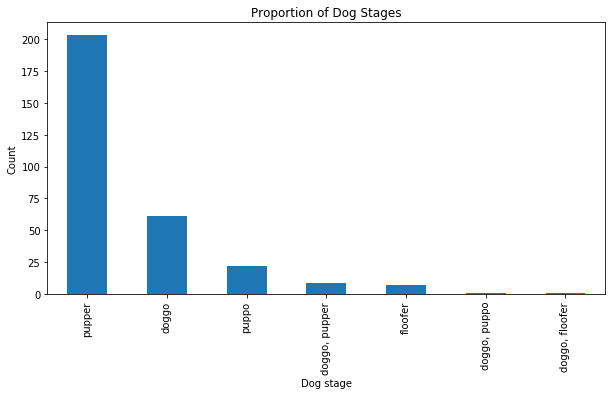

In [221]:
plt.figure(figsize=(10,5))
df_dogs.plot(kind = 'bar')
plt.xlabel('Dog stage')
plt.ylabel('Count')
plt.title('Proportion of Dog Stages');

We see that the dogs in the pupper stage are more in number compared to other dog stages

### Rating Numerator Distribution

In [199]:
df_numerator = df_clean_final_1['rating_numerator'].value_counts()
df_numerator

12.00      448
10.00      419
11.00      396
13.00      257
9.00       151
8.00       95 
7.00       51 
14.00      36 
6.00       32 
5.00       32 
3.00       19 
4.00       15 
2.00       9  
1.00       4  
0.00       2  
420.00     1  
9.50       1  
13.50      1  
11.26      1  
11.27      1  
1776.00    1  
Name: rating_numerator, dtype: int64

In [200]:
df_clean_final_1[df_clean_final_1['rating_numerator'] >=10].count()[0]

1561

Out of 1972, 1561 tweets have the numerator ratings above 10.

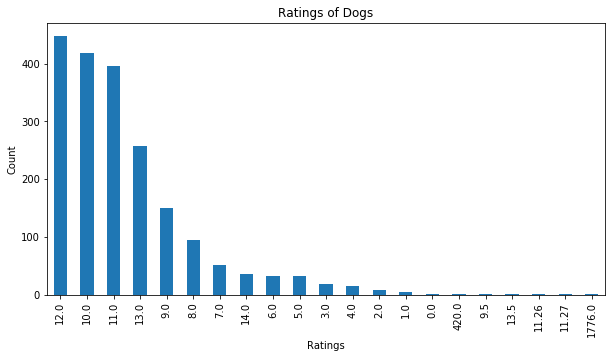

In [201]:
plt.figure(figsize=(10,5))
df_numerator.plot(kind = 'bar')
plt.xlabel('Ratings')
plt.ylabel('Count')
plt.title('Ratings of Dogs');

We see that 12 is the most assigned numerator rating for the dogs, followed by 11 and 10. Ratings below 10 are very less compared to the rating greater than 10 (12 and 11).

### The most commonly used source for writing the tweets

In [135]:
# The most commonly used source for the tweets
df_clean_final_1['source'].value_counts()

<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>     1934
<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>                     28  
<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>    10  
Name: source, dtype: int64

In [136]:
df_clean_final_1['source'].value_counts()/df_clean_final_1.count()[0]

<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>     0.980730
<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>                     0.014199
<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>    0.005071
Name: source, dtype: float64

We can see that 98% of people used iPhone for writing the tweets compared to Twitter Web Client or the TweetDeck

### The most rated Dog breed in the tweets 

In [215]:
# I have considered the 1st prediction of the dog breed for visualization and considered the top ten breeds.
df_dog_prediction = df_clean_final_1['dog_prediction_1'].value_counts(ascending = False).head(10)
df_dog_prediction

golden_retriever      136
labrador_retriever    90 
pembroke              88 
chihuahua             79 
pug                   54 
chow                  41 
samoyed               39 
pomeranian            38 
toy_poodle            37 
malamute              28 
Name: dog_prediction_1, dtype: int64

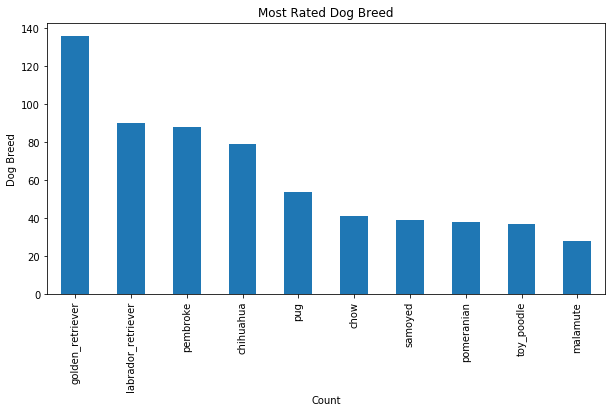

In [216]:
plt.figure(figsize=(10,5))
df_dog_prediction.plot(kind = 'bar')
plt.xlabel('Count')
plt.ylabel('Dog Breed')
plt.title('Most Rated Dog Breed');

We can see that from the first prediction of the dog breed, Golden Retriever is the most rated dog breed and the least rated is the malamute from the top 10 counts

### The most popular Dog names 

In [139]:
# Most frequently used dog names
df_name = df_clean_final_1['name'].value_counts(ascending = False).head(10)
df_name

Oliver     10
Charlie    10
Tucker     9 
Penny      9 
Lucy       9 
Cooper     9 
Winston    8 
Sadie      8 
Lola       7 
Daisy      7 
Name: name, dtype: int64

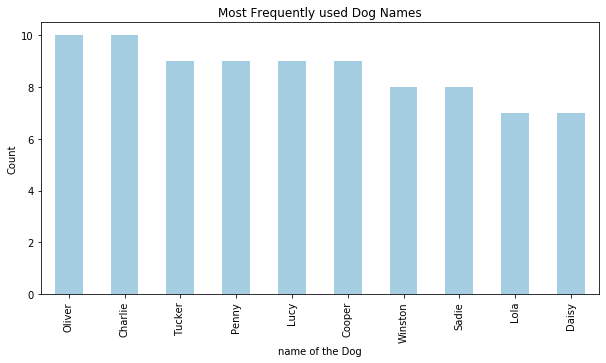

In [217]:
plt.figure(figsize=(10,5))
df_name.plot(kind='bar', colormap='Paired')
plt.xlabel('name of the Dog')
plt.ylabel('Count')
plt.title('Most Frequently used Dog Names');

We see that Cooper, Oliver and Charlie are the top three names that are frequently used

### Relation between the retweets and favorite counts

<Figure size 720x360 with 0 Axes>

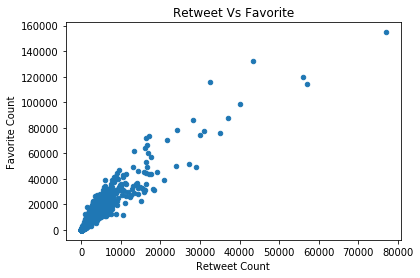

In [218]:
df_clean_final_1.plot(kind = 'scatter', x = 'retweet_count', y = 'favorite_count')
plt.xlabel('Retweet Count')
plt.ylabel('Favorite Count')
plt.title('Retweet Vs Favorite');

We can see that there is a positive co-relation between the retweets and favorite count. The more a post is retweeted, the more favorite counts or the more favorites the post recieves 

In [142]:
import datetime

In [143]:
df_clean_final_1['year'] = pd.DatetimeIndex(df_clean_final_1['timestamp']).year
df_clean_final_1['month'] = pd.DatetimeIndex(df_clean_final_1['timestamp']).month

C:\Users\Bindushree\anaconda3\envs\test_env\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\Bindushree\anaconda3\envs\test_env\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [144]:
# Drop the timestamp column
df_clean_final_1.drop('timestamp', axis = 1, inplace = True)

C:\Users\Bindushree\anaconda3\envs\test_env\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [145]:
df_clean_final_1.sample(3)

,tweet_id,source,name,dog_stage,rating_numerator,dog_prediction_1,retweet_count,favorite_count,year,month
672,667470559035432960,"<a href=""http://twitter.com"" rel=""nofollow"">Twitter Web Client</a>",NaN,,11.0,toy_poodle,89,243,2015,11
1160,870374049280663552,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Zoey,,13.0,golden_retriever,24321,78034,2017,6
698,674670581682434048,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Jeb,,9.0,malamute,617,1548,2015,12


### In which year was the most number of Tweets

In [169]:
df_year = df_clean_final_1['year'].value_counts()
df_year

2016    961
2015    659
2017    352
Name: year, dtype: int64

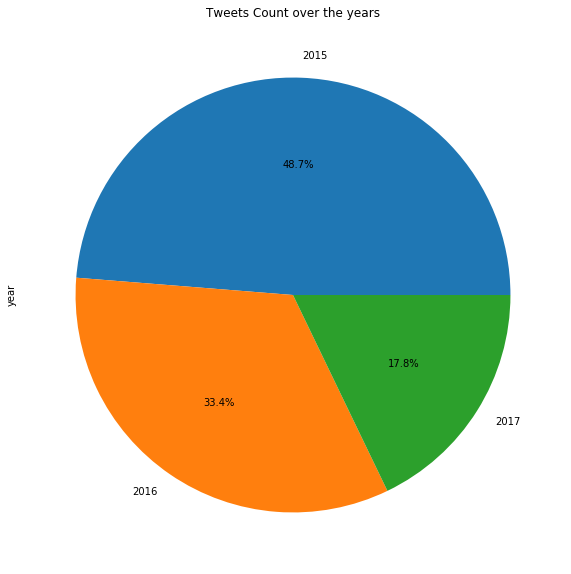

In [220]:
plt.figure(figsize=(15,10))
my_labels = '2015','2016','2017'
df_year.plot(kind = 'pie', labels = my_labels, subplots = True, autopct='%1.1f%%')
plt.title('Tweets Count over the years');

We see that almost half of the tweets (49%) were written in 2015, followed by 34% in 2016 and the least number of tweets in 2017 which is aoriund 18%